## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [ ]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=256 * 1 * 1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        # Dropout и Batch Normalization
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.batch_norm5 = nn.BatchNorm2d(256)

    def forward(self, x):
        # Прямой проход через сверточные слои с активациями и нормализацией
        x = torch.relu(self.batch_norm1(self.conv1(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.relu(self.batch_norm2(self.conv2(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.relu(self.batch_norm3(self.conv3(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.relu(self.batch_norm4(self.conv4(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.relu(self.batch_norm5(self.conv5(x)))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)

        # Прямой проход через полносвязные слои с dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170498071/170498071 [00:05<00:00, 32243983.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


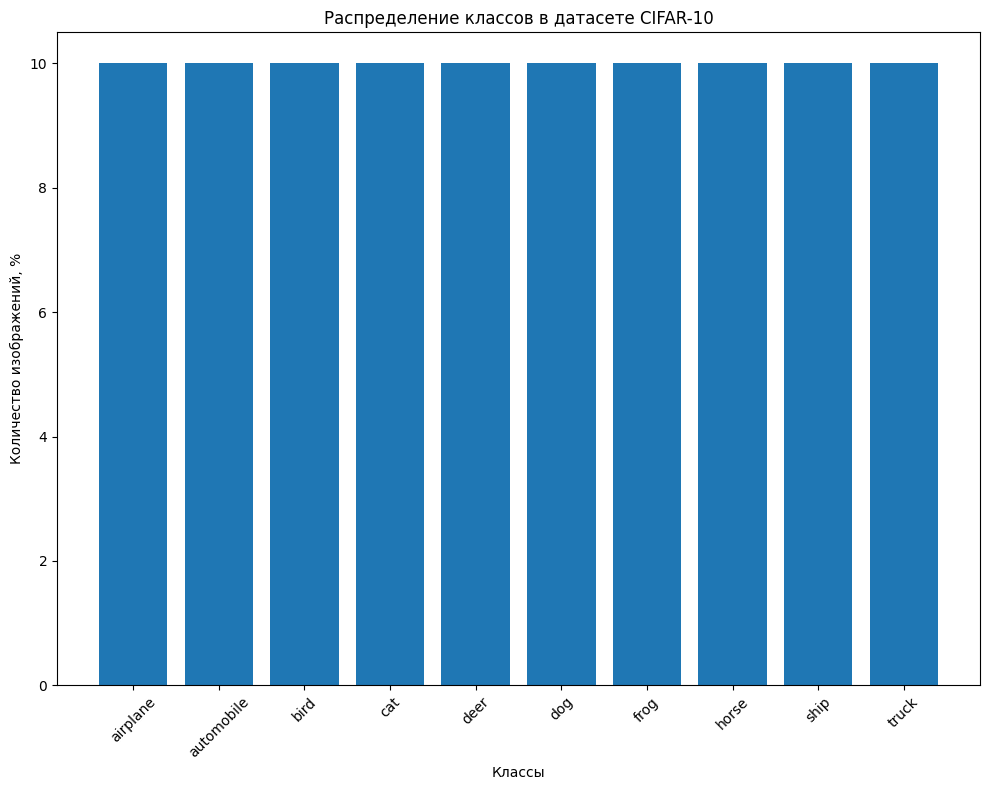

In [3]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [4]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            # Занулите градиенты оптимизатора
            optimizer.zero_grad()
            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Сделайте обратный проход
            loss.backward()
            # Сделайте шаг оптимизации
            optimizer.step()

            running_loss += loss.item()

            # Вычислите точность предсказания
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)
        correct = 0
        total = 0
        test_loss = 0.0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))
        with torch.no_grad():
            for batch_idx, (inputs, labels) in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        val_loss_history.append(test_loss / len(val_loader))
        val_acc_history.append(correct / total)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [ ]:
import torch.nn as nn
import torch

# Определение блока ResNet
class ResidualBlock(nn.Module):
    expansion = 4  # Добавим параметр expansion для ResidualBlock

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

# Определение ResNet
class ResNet152(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet152, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels * block.expansion):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Создание модели ResNet-152
def create_ResNet152(num_classes=10):
    return ResNet152(ResidualBlock, [3, 8, 36, 3], num_classes)


In [ ]:
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size

# train_dataset, val_dataset = train_test_split(train_dataset, test_size=val_size, random_state=42, shuffle=True)

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [ ]:
# # Гиперпараметры
# learning_rate = 0.001  # Выберите подходящую величину learning_rate
# num_epochs = 40  # Выберите количество эпох
# batch_size = 64  # Выберите размер батча

# import torchvision.models as models
# resnet152 = models.resnet152(pretrained=True)

# # Замена последнего слоя классификации
# num_classes = 10  # Число классов в CIFAR-10
# resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)

# model = resnet152
# model.to(device)
# print('Model params: ', count_parameters(model))

# # Определяем функцию потерь и оптимизатор
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Определение гиперпараметров
learning_rate = 0.001
num_epochs = 16
batch_size = 64

# Замена последнего слоя классификации для ResNet-152
import torchvision.models as models
resnet152 = models.resnet152(pretrained=True)
num_classes = 10
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)

# Определение модели
model = resnet152

print('Model params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Загрузка CIFAR-10
transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_to_test = transforms.Compose([
    transforms.ToTensor ( ),
    transforms.Normalize ( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms_to_test)


# Замена последнего слоя классификации для ResNet-152
import torchvision.models as models
resnet152 = models.resnet152(pretrained=True)
num_classes = 10
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)

# Определение модели
model = resnet152

print('Model params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Мир, Дружба, Жвачка!")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 88.7MB/s] 


Model params:  58164298
Files already downloaded and verified
Files already downloaded and verified
Model params:  58164298
Мир, Дружба, Жвачка!


In [ ]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

In [ ]:
indices = np.random.choice(len(test_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

In [6]:
%%time
num_epochs = 10
LastAccuracy = 0
iteratino=0
while (LastAccuracy < 87):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Epoch [{epoch+1+iteratino*10}/{num_epochs+iteratino*10}], Loss: {running_loss/(i+1):.4f}, Accuracy: {(correct/total)*100:.2f}%')


    # Оценка модели на тестовом датасете
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy on test set: {(correct/total)*100:.2f}%')
        LastAccuracy = int((correct/total)*100)
        iteratino+=1
    torch.save(model.state_dict(), f'resnet152_model epoch{iteratino*10} Accuracy {LastAccuracy:.2f}.pth')

Epoch [1/10], Loss: 1069.3566, Accuracy: 52.92%
Epoch [2/10], Loss: 873.1920, Accuracy: 61.14%
Epoch [3/10], Loss: 815.3425, Accuracy: 64.44%
Epoch [4/10], Loss: 741.9747, Accuracy: 67.41%
Epoch [5/10], Loss: 928.3425, Accuracy: 58.60%
Epoch [6/10], Loss: 923.2863, Accuracy: 58.51%
Epoch [7/10], Loss: 859.1034, Accuracy: 61.48%
Epoch [8/10], Loss: 679.6257, Accuracy: 69.73%
Epoch [9/10], Loss: 594.5834, Accuracy: 73.44%
Epoch [10/10], Loss: 545.9292, Accuracy: 75.94%
Accuracy on test set: 76.22%
Epoch [11/20], Loss: 260.6899, Accuracy: 77.03%
Epoch [12/20], Loss: 244.8187, Accuracy: 78.31%
Epoch [13/20], Loss: 232.6845, Accuracy: 79.50%
Epoch [14/20], Loss: 224.7682, Accuracy: 80.16%
Epoch [15/20], Loss: 229.3661, Accuracy: 79.84%
Epoch [16/20], Loss: 210.5001, Accuracy: 81.32%
Epoch [17/20], Loss: 196.2725, Accuracy: 82.70%
Epoch [18/20], Loss: 194.3190, Accuracy: 82.75%
Epoch [19/20], Loss: 203.6202, Accuracy: 82.01%
Epoch [20/20], Loss: 185.4125, Accuracy: 83.68%
Accuracy on test se

In [7]:
torch.save(model.state_dict(), 'resnet152_model.pth')

Обучите модель и постройте графики обучения

In [ ]:
# epochs = range(1, len(train_loss_history) + 1)

# # График функции потерь на тренировочных данных
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
# plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
# plt.title('Train and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # График точности на валидационных данных
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
# plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
# plt.title('Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model= ResNet9(3,10)
model.to(device)
model.load_state_dict(torch.load('resnet9_model.pth'))
model.eval()  # Установите модель в режим оценки

In [ ]:
import torchvision.models as models
resnet152 = models.resnet152(pretrained=True)
num_classes = 10
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)

# Определение модели
model = resnet152
model.to(device)
model.load_state_dict(torch.load('resnet152_model.pth'))
# model.eval()  # Установите модель в режим оценки

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [8]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4668
Test Accuracy: 0.8702


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов